<a href="https://colab.research.google.com/github/fkmoftakhar/hamrah.academy/blob/main/boston_mlp_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Boston Housing Regression with MLP

##Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Load the Dataset

The Boston Housing dataset is loaded using fetch_openml since load_boston is deprecated in recent scikit-learn versions.

In [2]:
# Load the Boston Housing dataset
housing = fetch_openml(name='boston', version=1, as_frame=True, parser='auto')
X = housing.data
y = housing.target.astype(float)  # Ensure target is float for regression

# Combine for analysis
df = pd.concat([X, pd.Series(y, name='MEDV')], axis=1)
print("Dataset loaded successfully. Shape:", X.shape)
print(df.head())

Dataset loaded successfully. Shape: (506, 13)
      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


Correlations with MEDV:
 MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


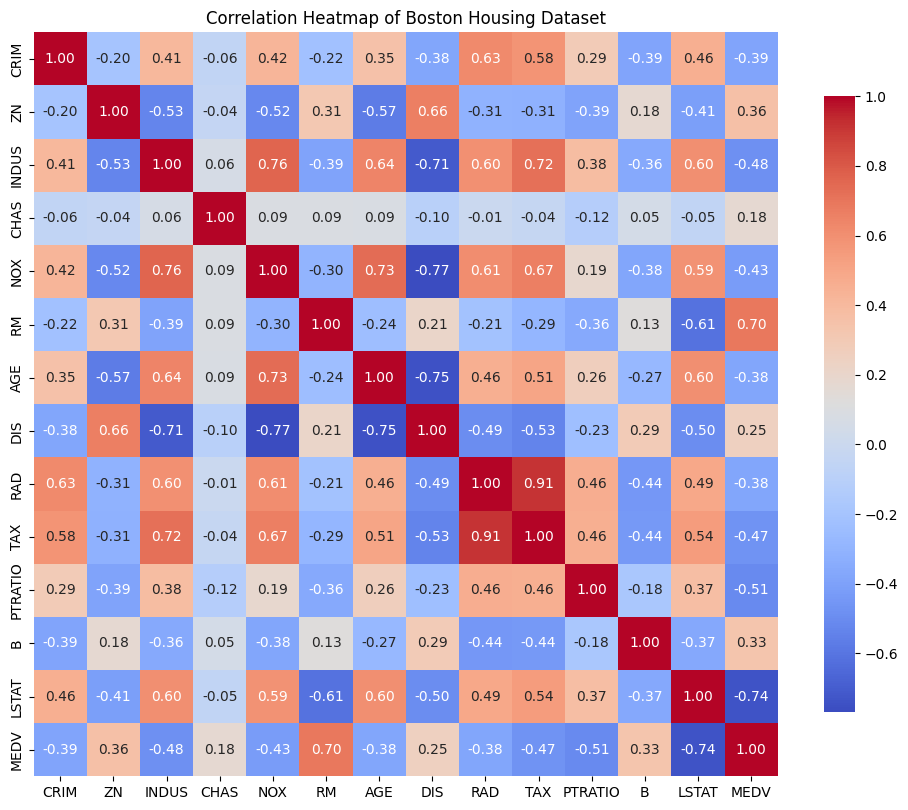

In [3]:
# Compute correlation matrix
corr_matrix = df.corr()

# Print correlations with MEDV for feature selection
print("Correlations with MEDV:\n", corr_matrix['MEDV'].sort_values(ascending=False))

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Boston Housing Dataset')
plt.show()

To select two features (RM and LSTAT), I looked at the row/column corresponding to the target (MEDV - house price):

The RM feature (average number of rooms) has a strong positive correlation of about 0.70, meaning that as the number of rooms increases, house prices tend to increase.
The LSTAT feature (percentage of low-income population) has a strong negative correlation of about -0.74, meaning that as the percentage of the population in low-income increases, house prices tend to decrease.
I chose these two features because they have the strongest correlations (one positive and one negative) with the target, which is useful for a two-dimensional regression model and provides variety (rather than choosing two similar features).

## Data Analysis and Feature Selection

In [4]:
# Compute correlations with target
corr = df.corr()['MEDV'].sort_values(ascending=False)
print("Correlations with MEDV:\n", corr)

# Select two features based on high correlation (positive and negative for diversity)
selected_features = ['RM', 'LSTAT']
X_selected = X[selected_features].astype(float)  # Ensure float types
print("\nSelected features:", selected_features)
print(X_selected.head())

Correlations with MEDV:
 MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

Selected features: ['RM', 'LSTAT']
      RM  LSTAT
0  6.575   4.98
1  6.421   9.14
2  7.185   4.03
3  6.998   2.94
4  7.147   5.33


## Basic Data Cleaning

In [5]:
# Check for missing values
print("Missing values:\n", X_selected.isnull().sum())

# Basic stats
print("\nData description:\n", X_selected.describe())

# No cleaning needed (no NaNs, no outliers removal for simplicity as per analysis)

Missing values:
 RM       0
LSTAT    0
dtype: int64

Data description:
                RM       LSTAT
count  506.000000  506.000000
mean     6.284634   12.653063
std      0.702617    7.141062
min      3.561000    1.730000
25%      5.885500    6.950000
50%      6.208500   11.360000
75%      6.623500   16.955000
max      8.780000   37.970000


## Train-Test Split

Split the data into training and testing sets (80/20) before scaling.

In [6]:
# Split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print("Train shape:", X_train_raw.shape)
print("Test shape:", X_test_raw.shape)

Train shape: (404, 2)
Test shape: (102, 2)


## Scaling (After Split)
Scale features for better MLP performance: Fit scaler only on train data, then transform both train and test.

In [7]:
# Scale features for neural network stability
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
print("\nScaled train data sample:\n", X_train[:5])
print("\nScaled test data sample:\n", X_test[:5])


Scaled train data sample:
 [[-1.42806858  1.75350503]
 [-0.68008655 -0.5614742 ]
 [-0.40206304 -0.65159505]
 [-0.30045039  1.52538664]
 [-0.83109424 -0.16578736]]

Scaled test data sample:
 [[ 0.14128239 -0.48121032]
 [ 0.62394249 -1.25709448]
 [-0.46980481  0.79033849]
 [-0.35407929 -0.97687498]
 [-0.02666075  0.67768743]]


## Train MLP Regressor

In [8]:
# Initialize and train MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                   max_iter=1000, random_state=42, tol=1e-4)
mlp.fit(X_train, y_train)
print("Model trained. Loss:", mlp.loss_)

Model trained. Loss: 10.729855646712597


## Evaluate Model

In [9]:
# Predict and evaluate
y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

# Optional: Print sample predictions
print("\nSample predictions vs actual:\n", pd.DataFrame({'Actual': y_test[:5], 'Predicted': y_pred[:5]}))

Mean Squared Error on Test Set: 19.860210385361025

Sample predictions vs actual:
      Actual  Predicted
173    23.6  24.094360
274    32.4  32.004166
491    13.6  13.977888
72     22.8  26.040252
452    16.1  15.366359


## 3D Visualization

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


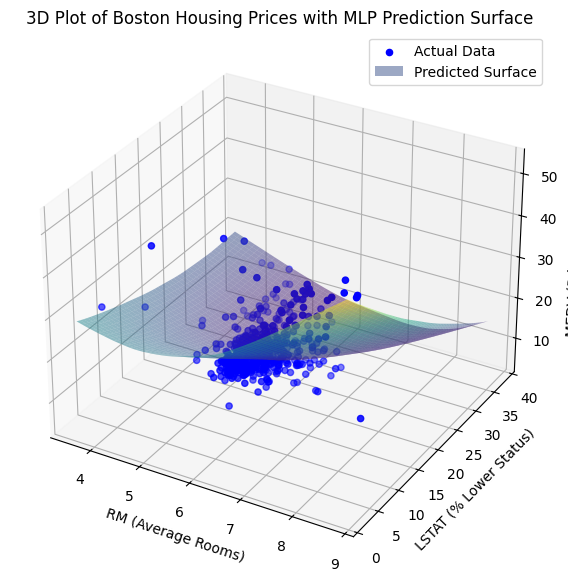

In [10]:
# Prepare meshgrid for surface plot (using original scale for visualization)
rm_min, rm_max = X_selected['RM'].min(), X_selected['RM'].max()
lstat_min, lstat_max = X_selected['LSTAT'].min(), X_selected['LSTAT'].max()
rm_grid, lstat_grid = np.meshgrid(np.linspace(rm_min, rm_max, 50),
                                  np.linspace(lstat_min, lstat_max, 50))

# Scale the meshgrid points
mesh_points = np.c_[rm_grid.ravel(), lstat_grid.ravel()]
mesh_scaled = scaler.transform(mesh_points)

# Predict on mesh
z_pred = mlp.predict(mesh_scaled).reshape(rm_grid.shape)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter actual points (using original features)
ax.scatter(X_selected['RM'], X_selected['LSTAT'], y, c='blue', marker='o', label='Actual Data')

# Plot predicted surface
ax.plot_surface(rm_grid, lstat_grid, z_pred, cmap='viridis', alpha=0.5, label='Predicted Surface')

ax.set_xlabel('RM (Average Rooms)')
ax.set_ylabel('LSTAT (% Lower Status)')
ax.set_zlabel('MEDV (Price in $1000s)')
ax.set_title('3D Plot of Boston Housing Prices with MLP Prediction Surface')
plt.legend()
plt.show()